In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from data import generate_balanced_pre_ictal_train_data

# generate_balanced_pre_ictal_train_data(256, 256, ["chb01", "chb02", "chb03"], 300, "ml_processed_balanced_pre_ictal_5m")

c:\Users\angus\Documents\cs408-eeg-python\data.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(seizure_data.filename, verbose=False)
c:\Users\angus\Documents\cs408-eeg-python\data.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(seizure_data.filename, verbose=False)
c:\Users\angus\Documents\cs408-eeg-python\data.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(seizure_data.filename, verbose=False)
c:\Users\angus\Documents\cs408-eeg-python\data.py:152: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(seizure_data.filename, verbose=False)
c:\Users\angus\Documents\cs408-eeg-p

In [107]:
from data import get_seizure_data
cases = ["chb01", "chb02", "chb03", "chb04", "chb05", "chb06", "chb07", "chb08", "chb09", "chb10", "chb11", "chb12", "chb13", "chb14", "chb15", "chb16", "chb17", "chb18", "chb19", "chb20", "chb21", "chb22", "chb23", "chb24"]
for case in cases:
    datas = get_seizure_data(case)
    case_seizure_count = 0
    for data in datas:
        case_seizure_count += data.seizure_count
    print(case, case_seizure_count)

chb01 7
chb02 3
chb03 7
chb04 4
chb05 5
chb06 9
chb07 2
chb08 5
chb09 3
chb10 6
chb11 2
chb12 35
chb13 9
chb14 8
chb15 20
chb16 10
chb17 3
chb18 5
chb19 2
chb20 7
chb21 4
chb22 3
chb23 7
chb24 16


In [74]:
# return to chb04, 07, really struggling for some reason
# chb15 corrupt
# revisit chb22, one FP
case = "chb17"

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from keras import backend as keras
from tensorflow import keras

import numpy as np
import os

In [7]:
# test_cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb01" in x or "chb02" in x or "chb03" in x or "chb04" in x or "chb05" in x or "chb06" in x or "chb07" in x or "chb08" in x]
# test_cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb02" in x or "chb03" in x or "chb04" in x or "chb05" in x or "chb07" in x or "chb08" in x or "chb09" in x]
# cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if not "chb01" in x and "chb" in x]

In [69]:
cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb" in x and x != "chb04" and x != "chb07" and x != "chb15" and x != "chb17" and x != "chb18" and x != "chb20"]
cases = ["chb18"]
from seizure_sequence import SeizureSequence
seizure_sequence_balanced = SeizureSequence(1, "ml_processed_balanced_pre_ictal", cases)
whole_file_sequence = SeizureSequence(1, "ml_processed_pre_ictal", cases)
# five_min_sequence = SeizureSequence(1, "ml_processed_balanced_pre_ictal_5m", case)

IndexError: list index out of range

In [9]:
# print(five_min_sequence.__getitem__(0)[0].shape)

(599, 23, 256)


In [65]:
from model import ModelTools
m = ModelTools()
model = m.compile_model(m.create_model(dropout=True))
model.summary()
histories = []

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 19, 512)           655872    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 9, 512)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 9, 512)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 7, 256)            393472    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 3, 256)           0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 3, 256)           

In [66]:
# history_with_whole_file = model.fit(whole_file_sequence, epochs=1)
history = model.fit(seizure_sequence_balanced, epochs=1500)
histories.append(history)

Epoch 1/1500
5/5 [==============================] - 1s 43ms/step - loss: 0.6933 - accuracy: 0.4675
Epoch 2/1500
5/5 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5125
Epoch 3/1500
5/5 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/1500
5/5 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5125
Epoch 5/1500
5/5 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4800
Epoch 6/1500
5/5 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5175
Epoch 7/1500
5/5 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4475
Epoch 8/1500
5/5 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.4850
Epoch 9/1500
5/5 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5150
Epoch 10/1500
5/5 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.5050
Epoch 11/1500
5/5 

KeyboardInterrupt: 

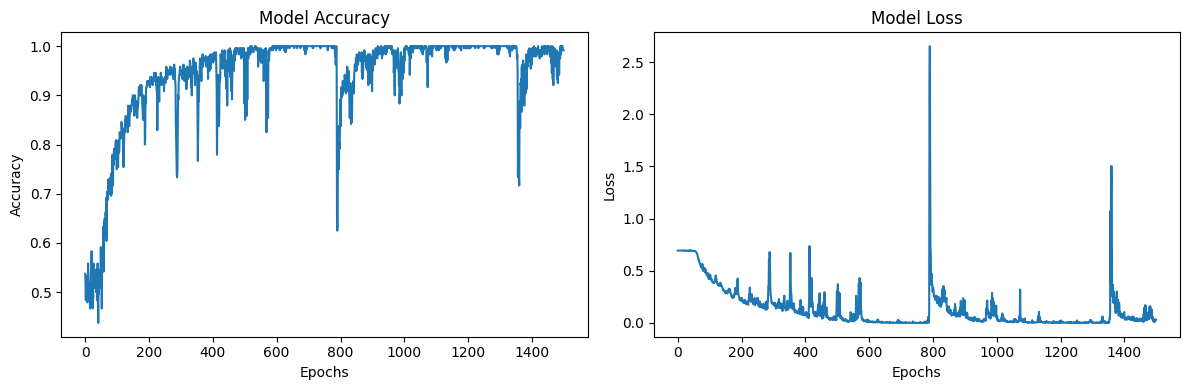

In [ ]:
m.accuracy_loss_plot(histories)

# combined_history = {}
# for key in history.history.keys():
#     # combined_history[key] = history.history[key] + history_with_whole_file.history[key]
#     combined_history[key] = history_with_whole_file.history[key] + history.history[key]

    
# accuracy_loss_plot(combined_history, combined=True)

In [79]:
print(seizure_sequence_balanced.get_test_file())

chb02_16+.edf_pre_ictal


In [67]:
# model = keras.models.load_model("models/new_arch/chb24_threshold_0.59_false_neg_0_true_neg_1995_false_pos_1540_true_pos_39_accuracy_57_regularised.h5")
case = "chb17"
seizure_sequence_balanced = SeizureSequence(1, "ml_processed_balanced_pre_ictal", cases)

file = seizure_sequence_balanced.get_test_file()
whole_file_data = np.load("ml_processed_pre_ictal/" + file + "_data.npy")
whole_file_labels = np.load("ml_processed_pre_ictal/" + file + "_labels.npy")
print(np.count_nonzero(whole_file_labels))

print(whole_file_data.shape)
predictions = model.predict(whole_file_data)

threshold = 0.2
best_threshold = threshold
best_accuracy = 0
lowest_false_neg = float('inf')
for i in range(0, 801):
    false_pos = 0
    true_pos = 0
    false_neg = 0
    true_neg = 0
    for i, prediction in enumerate(predictions):
        p = prediction[0][0]
        # if p == 1:
        if p > threshold:
            if whole_file_labels[i] == 0:
                false_pos += 1
            else:
                true_pos += 1
        else:
            if whole_file_labels[i] == 1:
                false_neg += 1
            else:
                true_neg += 1
    whole_file_accuracy = ((true_pos + true_neg) / whole_file_data.shape[0]) * 100
    if (false_neg <= lowest_false_neg or false_neg <= 0) and true_pos > 0 and whole_file_accuracy > best_accuracy:
        lowest_false_neg = false_neg
        best_accuracy = whole_file_accuracy
        best_threshold = threshold
    threshold = round(threshold + 0.001, 3)

# print(f"Best threshold: {best_threshold}\nBest accuracy: {best_accuracy} \nLowest false neg: {lowest_false_neg}")


# best_threshold = 0.91
false_pos = 0
true_pos = 0
false_neg = 0
true_neg = 0
for i, prediction in enumerate(predictions):
    p = prediction[0][0]
    # if p == 1:
    if p > best_threshold:
        if whole_file_labels[i] == 0:
            false_pos += 1
        else:
            true_pos += 1
    else:
        if whole_file_labels[i] == 1:
            false_neg += 1
        else:
            true_neg += 1
whole_file_accuracy = ((true_pos + true_neg) / whole_file_data.shape[0]) * 100
print("\t false", "\t", "true")
print("pos \t", false_pos, "\t", true_pos)
print("neg \t", false_neg, "\t", true_neg)
print(f"\nBest Threshold: {best_threshold}, Correct: {round(whole_file_accuracy, 2)}%")
print(f"{case} & {best_threshold}\t  & {false_neg}\t\t\t   & {true_neg}\t\t   & {false_pos}\t\t\t& {true_pos}\t\t\t& {round(whole_file_accuracy)}\t   \\\\")

if False and false_neg == 0:
    model.save("models/" + case + "_threshold_" + str(best_threshold) + "_accuracy_" + str(round(best_accuracy)) + ".h5")

39
(3509, 23, 256)
110/110 [==============================] - 1s 4ms/step
	 false 	 true
pos 	 1229 	 39
neg 	 0 	 2241

Best Threshold: 0.472, Correct: 64.98%
chb17 & 0.472	  & 0			   & 2241		   & 1229			& 39			& 65	   \\


In [24]:
print(f"{case} & {best_threshold}\t  & {false_neg}\t\t\t   & {true_neg}\t\t   & {false_pos}\t\t\t& {true_pos}\t\t\t& {round(whole_file_accuracy)}\t   \\\\")

chb06 & 0.336	  & 1			   & 8368		   & 5973			& 69			& 59	   \\


In [68]:
model.save("models/new_arch/" + case + "_threshold_" + str(best_threshold) + "_false_neg_" + str(false_neg) + "_true_neg_" + str(true_neg) + "_false_pos_" + str(false_pos) + "_true_pos_" + str(true_pos) + "_accuracy_" + str(round(best_accuracy)) + "_regularised.h5")

In [15]:
# model.save("models/" + case + "_threshold_" + str(best_threshold) + "_accuracy_" + str(best_accuracy) + ".h5")
# # model.save("models/" + case + "_whole_file_trained_" + str(whole_file_accuracy) + ".h5")

In [84]:
for p in predictions:
    print(p[0][0])

0.044000544
0.0010239289
0.084114365
0.0126095805
0.0040098648
1.0436518e-05
4.703993e-16
0.0035324453
0.13459288
0.0002604694
7.468752e-13
0.0011763844
4.9195795e-16
4.3448856e-27
4.2470298e-16
9.115339e-27
9.077663e-14
0.011669856
3.8396996e-05
0.0011839636
0.0006061875
0.00036463054
0.010705533
0.023918612
0.022982407
2.3631068e-16
3.5351755e-32
3.3584634e-29
0.0
4.399097e-23
2.9597985e-15
0.00094408996
0.073521644
0.040457632
3.6983894e-07
0.036906052
0.0022969893
1.9490462e-05
0.0010967071
0.06890351
0.003219404
0.92522866
2.2120428e-08
2.4295652e-19
0.26972324
0.94339055
8.568177e-13
0.0007485834
0.003788244
7.564849e-07
0.55516034
0.0044732974
0.87628794
0.00031674054
0.99992096
0.002766922
2.25361e-07
2.1478685e-09
0.78673875
0.4652887
0.09496781
0.0022872495
0.99173087
0.055237774
0.37701407
0.8985389
0.9673061
0.9730042
0.9320419
0.83344173
0.19234377
0.0067052157
0.00030528053
0.0009747461
0.0
6.099794e-21
7.739892e-05
0.7460024
0.9872317
1.5574242e-05
3.9490317e-11
0.170914